# Chapter 6 - Linear Model Selection and Regularization

In [1]:
import itertools
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import scale, StandardScaler
from tqdm import tnrange
%matplotlib inline

BASE_DIR = 'https://gitlab.com/machine-learning-course1/ml-practice-lg-2024-spring/-/raw/master/Notebooks'

## 1. Model Selection Methods

Reference link : https://xavierbourretsicotte.github.io/subset_selection.html#Comparing-models:-AIC,-BIC,-Mallows'CP

### 1.1. Load dataset
The credit dataset is a use case for linear regression where some predictors are qualitative.

In [2]:
credit = pd.read_csv(f'{BASE_DIR}/Data/Credit.csv')
credit = credit.drop(columns=['Unnamed: 0'])
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580


### 1.2. Encoding qualitative data

In [3]:
credit = pd.get_dummies(credit, columns=['Gender', 'Student','Married', 'Ethnicity'], drop_first=True)
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,333,False,False,True,False,True
1,106.025,6645,483,3,82,15,903,True,True,True,True,False
2,104.593,7075,514,4,71,11,580,False,False,False,True,False


<a id='subset'></a>
### 1.3. Best Subset Selection
To perform best selection, we fit separate models for each possible combination of the n predictors and then select the best subset. That is we fit:

- All models that contains exactly one predictor
- All models that contain 2 predictors at the second step
- All models that contain 3 predictors at the thrid step
- ...
- Until reaching the end point where all n predictors are included in the model

This results in 2n possibilities as this is a power set problem. In our case there are 2^11=2048 possible combinations

### 1.4. Helper function for fitting linear regression (Sklearn)

In [4]:
def fit_linear_reg(X, Y_true):
    """Fit linear regression model and return RSS and R squared values"""
    model_k = LinearRegression()
    Y_pred = model_k.fit(X, Y_true).predict(X)
    RSS = mean_squared_error(Y_true, Y_pred) * len(Y)
    R_squared = model_k.score(X, Y_true)
    return RSS, R_squared

### 1.5. Implementing Best subset selection (using itertools.combinations)

In [5]:
# Initialization variables
Y = credit['Balance']
X = credit.drop(columns=['Balance'])

RSS_list, R_squared_list, features_list, num_features_list = [], [], [], []

# Looping over k = 1 to k = 11 features in X
for k in tnrange(1, len(X.columns) + 1):
    # Looping over all possible combinations: from 11 choose k
    for features in itertools.combinations(X.columns, k):
        features = list(features)
        RSS, R_squared = fit_linear_reg(X[features], Y)  # Store temp result
        RSS_list.append(RSS)                  # Append lists
        R_squared_list.append(R_squared)
        features_list.append(features)
        num_features_list.append(len(features))

# Store in DataFrame
df = pd.DataFrame({
    'num_features': num_features_list,
    'RSS': RSS_list,
    'R_squared': R_squared_list,
    'features': features_list,
})
df.head()

  0%|          | 0/11 [00:00<?, ?it/s]

,num_features,RSS,R_squared,features
0,1,6.620874e+07,0.214977,[Income]
1,1,2.171566e+07,0.742522,[Limit]
2,1,2.143512e+07,0.745848,[Rating]
3,1,8.370950e+07,0.007475,[Cards]
4,1,8.433963e+07,0.000003,[Age]


### 1.6. Finding the best subsets for each number of features
Using the smallest RSS value, or the largest R_squared value

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [6]:
print(pd.DataFrame({
    'name': ['a', 'b', 'a', 'b'],
    'height': [100, 200, 300, 400],
}).groupby('name').mean())

      height
name        
a      200.0
b      300.0


In [7]:
print(pd.DataFrame({
    'name': ['a', 'b', 'a', 'b'],
    'height': [100, 200, 300, 400],
}).groupby('name').transform(sum))

   height
0     400
1     600
2     400
3     600


In [8]:
df_min = df[df.groupby('num_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('num_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))

,num_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,[Rating]
12,2,1.053254e+07,0.875118,"[Income, Rating]"
79,3,4.227219e+06,0.949879,"[Income, Rating, Student_Yes]"


,num_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,[Rating]
12,2,1.053254e+07,0.875118,"[Income, Rating]"
79,3,4.227219e+06,0.949879,"[Income, Rating, Student_Yes]"


### 1.7. Adding columns to the dataframe with RSS and R squared values of the best subset

In [9]:
df['min_RSS'] = df.groupby('num_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('num_features')['R_squared'].transform(max)
df.head()

,num_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,6.620874e+07,0.214977,[Income],2.143512e+07,0.745848
1,1,2.171566e+07,0.742522,[Limit],2.143512e+07,0.745848
2,1,2.143512e+07,0.745848,[Rating],2.143512e+07,0.745848
3,1,8.370950e+07,0.007475,[Cards],2.143512e+07,0.745848
4,1,8.433963e+07,0.000003,[Age],2.143512e+07,0.745848


### 1.8. Plotting the best subset selection process

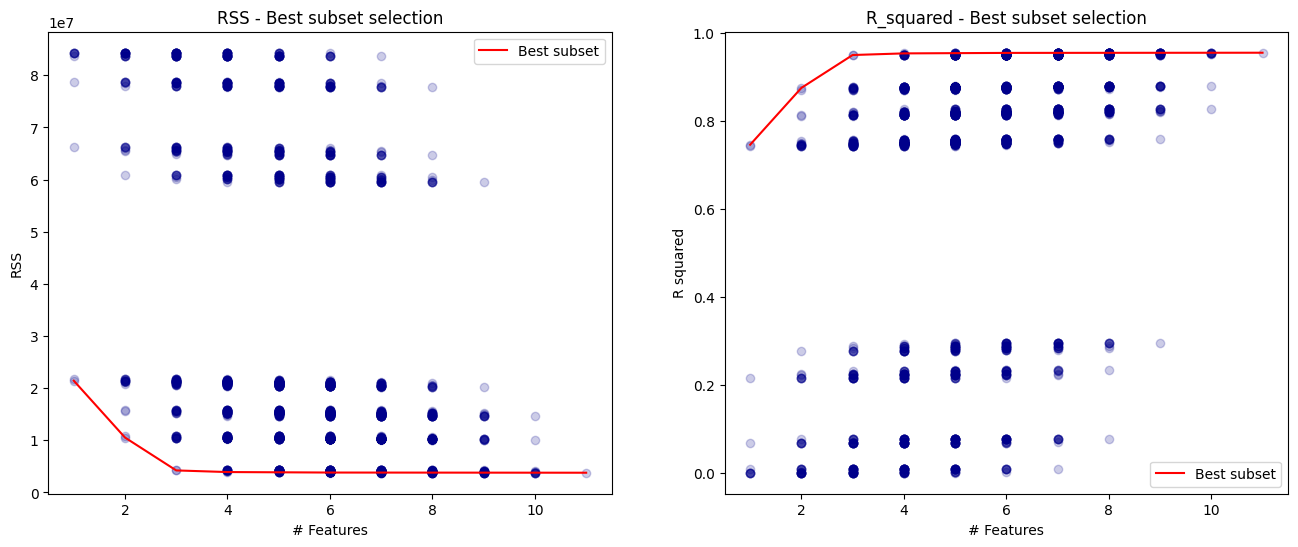

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].scatter(df['num_features'], df['RSS'], alpha=0.2, color='darkblue')
axes[0].plot(df['num_features'], df['min_RSS'], color='r', label='Best subset')

axes[0].set_xlabel('# Features')
axes[0].set_ylabel('RSS')
axes[0].set_title('RSS - Best subset selection')
axes[0].legend()


axes[1].scatter(df['num_features'], df['R_squared'], alpha=0.2, color='darkblue')
axes[1].plot(df['num_features'], df['max_R_squared'], color='r', label='Best subset')

axes[1].set_xlabel('# Features')
axes[1].set_ylabel('R squared')
axes[1].set_title('R_squared - Best subset selection')
axes[1].legend()

plt.show()

<a id='forward'></a>
### 1.9. Forward stepwise selection
For computational reasons, the best subset cannot be applied for any large n due to the 2^n complexity.

Forward Stepwise begins with a model containing no predictors, and then adds predictors to the model, one at the time.

At each step, the variable that gives the greatest additional improvement to the fit is added to the model.

### Algorithm
Let M0 denote the null model which contains no predictors

- For k=1, 2, ... , n−1
    - Consider all n−k models that augment the predictors in Mk with one additional predictor
    - Choose the 'best' among these n−k models, and call it Mk+1
- Select the single best model among M0,M1,...,Mn using cross validated predicton error, Cp, BIC, adjusted R2 or any other method.

In [11]:
# Initialization variables
Y = credit['Balance']
X = credit.drop(columns=['Balance'])

remaining_features = list(X.columns)
features = []
RSS_dict, R_squared_dict, features_dict = {}, {}, {}

for k in tnrange(1, len(X.columns) + 1):

    best_RSS = np.inf
    for feature in remaining_features:
        RSS, R_squared = fit_linear_reg(X[features + [feature]], Y)
        if RSS < best_RSS:
            best_RSS = RSS
            best_R_squared = R_squared
            best_feature = feature

    # Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    assert len(features) == k

    # Saving values for plotting
    RSS_dict[k] = best_RSS
    R_squared_dict[k] = best_R_squared
    features_dict[k] = features.copy()

forward_results = RSS_dict, R_squared_dict, features_dict

  0%|          | 0/11 [00:00<?, ?it/s]

### 1.10. Displaying results of the first 4 steps

In [12]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')

for k in range(1, 5):
    print(k, round(RSS_dict[k]), features_dict[k])

Forward stepwise subset selection
Number of features | Features | RSS
1 21435122 ['Rating']
2 10532541 ['Rating', 'Income']
3 4227219 ['Rating', 'Income', 'Student_Yes']
4 4032502 ['Rating', 'Income', 'Student_Yes', 'Limit']


### 1.11. Exercise - Backward stepwise selection
For computational reasons, the best subset cannot be applied for any large n due to the 2^n complexity.
Backward Stepwise begins with a model containing all predictors, and then removes predictors to the model, one at the time.
At each step, the variable that gives the smallest additional improvement to the fit is removed from the model.

1. Implement Backward stepwise selection (Refer to Section 1.9.)
2. Display the results of the first 4 steps (Refer to Section 1.10.)

In [13]:
# Implement Backward stepwise selection (Refer to Section 1.9.)
# Initialization variables
Y = credit['Balance']
X = credit.drop(columns=['Balance'])

remaining_features = list(X.columns)
RSS_dict, R_squared_dict, features_dict = {}, {}, {}

for k in tnrange(len(X.columns), 0, -1):

    best_RSS = np.inf
    for features in itertools.combinations(remaining_features, k):
        features = list(features)
        RSS, R_squared = fit_linear_reg(X[features], Y)
        if RSS < best_RSS:
            best_RSS = RSS
            best_R_squared = R_squared
            best_features = features

    # Updating variables for next loop
    remaining_features = best_features

    # Saving values for plotting
    RSS_dict[k] = best_RSS
    R_squared_dict[k] = best_R_squared
    features_dict[k] = best_features.copy()

  0%|          | 0/11 [00:00<?, ?it/s]

In [14]:
# Display the results of the first 4 steps (Refer to Section 1.10.)
print('Backward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
for k in range(len(X.columns), 5, -1):
    print(k, round(RSS_dict[k]), features_dict[k])

Backward stepwise subset selection
Number of features | Features | RSS
11 3786730 ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender_Female', 'Student_Yes', 'Married_Yes', 'Ethnicity_Asian', 'Ethnicity_Caucasian']
10 3791345 ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Gender_Female', 'Student_Yes', 'Married_Yes', 'Ethnicity_Asian', 'Ethnicity_Caucasian']
9 3798367 ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Gender_Female', 'Student_Yes', 'Married_Yes', 'Ethnicity_Asian']
8 3804746 ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Gender_Female', 'Student_Yes', 'Ethnicity_Asian']
7 3810759 ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Gender_Female', 'Student_Yes']
6 3821620 ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Student_Yes']


<a id='compare'></a>
## 2. Comparing models: AIC, BIC, Mallows'CP
The training set Mean Squared Error (MSE) is generally an underestimate of the test MSE. This is because when we fit a model to the training data using least squares, we specifically estimate the regression coefficients such that the training RSS is minimized. In particular, the training RSS decreases as we add more features to the model, but the test error may not. Therefore the training RSS and $R^2$ may not be used for selecting the best model unless we adjust for this underestimation.

###  Theoretical justification
$C_p$, AIC, BIC all have rigorous theoretical justification that rely on asymptotic arguments, i.e. when the sample size $m$ grows very large, whereas the adjusted $R^2$, although quite intuitive, is not as well motivated in statistical theory.

### Combining forward stepwise results into a new DataFrame

In [15]:
RSS_dict, R_squared_dict, features_dict = forward_results

k_list = sorted(features_dict.keys())

df = pd.DataFrame({
    'RSS': [RSS_dict[k] for k in k_list],
    'R_squared': [R_squared_dict[k] for k in k_list],
    'features': [features_dict[k] for k in k_list],
    'num_features': k_list
})
df.head()

,RSS,R_squared,features,num_features
0,2.143512e+07,0.745848,[Rating],1
1,1.053254e+07,0.875118,"[Rating, Income]",2
2,4.227219e+06,0.949879,"[Rating, Income, Student_Yes]",3
3,4.032502e+06,0.952188,"[Rating, Income, Student_Yes, Limit]",4
4,3.866091e+06,0.954161,"[Rating, Income, Student_Yes, Limit, Cards]",5


### 2.1. Computing the C_p, AIC, BIC and R-square adjusted
### Estimation of $\hat\sigma^2$
Using the RSS of the full model with $p$ features, (i.e.the smallest RSS) we estimate $\hat\sigma^2$ as: $$ \hat\sigma^2 = \frac{RSS}{m - p -1} $$

In [16]:
# sample number
m = len(Y)
# predictor number
p = 11
hat_sigma_squared = min(df['RSS']) / (m - p - 1)

### Mallow's $C_p$
Mallow's $C_p$ is named after Colin Lingwood Mallows and is defined as: $$ C_p = \frac{1}{m} (RSS + 2d\hat\sigma^2)$$ where $\hat\sigma^2$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement. Typically $\hat\sigma^2$ is estimated using the full model containing all predictors. Essentially,the $C_p$ statistic adds a penalty of $2d\hat\sigma^2$ to the training RSS in order to adjust for the fact that the training error tends to underestimate the test error. Clearly, the penalty increases as the number of predictors in the model increases, and this is intended to adjust for the corresponding decrease in training RSS. It can be shown that if $\hat\sigma^2$ is an unbiased estimate of $\sigma^2$ then $C_p$ is an unbiased estimate of the test MSE, so we choose the model with the smallest $C_p$.

In [17]:
df['C_p'] = (1 / m) * (df['RSS'] + 2 * df['num_features'] * hat_sigma_squared)

### Akaike's Information Criteria (AIC)
The AIC criterion is defiend for a large class of models fit by maximum likelihood. In the case of a linear model with Gaussian errors, MLE and least squares are the same thing and the AIC is given by $$ AIC = \frac{1}{m\hat \sigma^2} (RSS + 2d\hat\sigma^2)$$

In [18]:
df['AIC'] = (1 / (m * hat_sigma_squared)) * (df['RSS'] + 2 * df['num_features'] * hat_sigma_squared)

### 2.2 Exercise

Calculate BIC & Adjusted $R^2$ to dataframe

### Bayesian Information Criteria (BIC)
BIC is derived from a Bayesian point of view, and looks similar to the $C_p$ and $AIC$ - it is defined (up to irrelevant constants) as: $$ BIC = \frac{1}{m\hat \sigma^2} (RSS + \log(m) d \hat\sigma^2)$$ Like $C_p$ and AIC, the BIC will tend to take small values for a model with low test error.

In [19]:
# Calculate BIC as df['BIC']
df['BIC'] = (1 / (m * hat_sigma_squared)) * (df['RSS'] +  np.log(m) * df['num_features'] * hat_sigma_squared)

### Adjusted $R^2$
Since the $R^2$ always increases as more variables are added, the adjusted $R^2$ accounts for that fact and introduces a penalty. The intuition is that once all the correct variables have been included in the model,additional _noise_ variables will lead to a very small decrase in RSS, but an increase in $k$ and hence will decrease the adjusted $R^2$. In effect, we pay a price for the inclusion of unnecessary variables in the model. $$ R_{a}^2 = 1 - \frac{RSS / (m - k -1)}{TSS / (m - 1)} = 1 - (1 - R^2) \frac{m - 1}{m - k - 1} $$

In [20]:
# Calculate Adjusted R^2 as df['R_squared_adj']
df['R_squared_adj'] = 1 - ((1 - df['R_squared']) * (m - 1) / (m - df['num_features'] - 1))

In [21]:
df.head()

,RSS,R_squared,features,num_features,C_p,AIC,BIC,R_squared_adj
0,2.143512e+07,0.745848,[Rating],1,53636.603151,5.495771,5.505750,0.745210
1,1.053254e+07,0.875118,"[Rating, Income]",2,26428.949364,2.707991,2.727949,0.874489
2,4.227219e+06,0.949879,"[Rating, Income, Student_Yes]",3,10714.442485,1.097835,1.127771,0.949499
3,4.032502e+06,0.952188,"[Rating, Income, Student_Yes, Limit]",4,10276.446437,1.052956,1.092871,0.951703
4,3.866091e+06,0.954161,"[Rating, Income, Student_Yes, Limit, Cards]",5,9909.218362,1.015329,1.065222,0.953579


### 2.3. Find a best model based on a Adjusted $R^2$

In [22]:
print(df['R_squared_adj'].idxmax())
print(df['R_squared_adj'].max())

6
0.9540098163629882


### 2.4. Plotting the computed values as a function of number of features

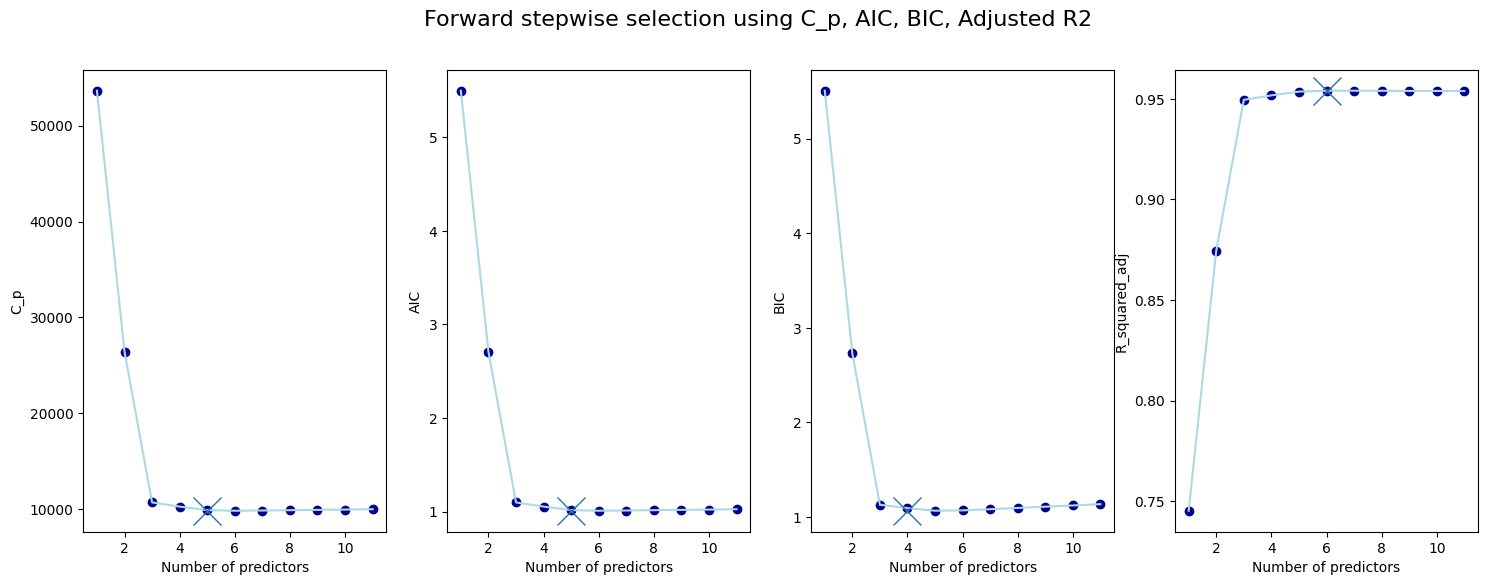

In [23]:
variables = ['C_p', 'AIC', 'BIC', 'R_squared_adj']
fig, axes = plt.subplots(nrows=1, ncols=len(variables) , figsize=(18, 6))

for v, ax in zip(variables, axes):
    ax.plot(df['num_features'], df[v], color='lightblue')
    ax.scatter(df['num_features'], df[v], color='darkblue')
    if v == 'R_squared_adj':
        ax.plot(df[v].idxmax(), df[v].max(), marker='x', markersize=20)
    else:
        ax.plot(df[v].idxmin(), df[v].min(), marker='x', markersize=20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Forward stepwise selection using C_p, AIC, BIC, Adjusted R2', fontsize=16)
plt.show()

## 3. Ridge Regression

### 3.1. Load dataset

In [24]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
hitters = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [25]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [26]:
hitters = pd.get_dummies(hitters, columns=['League', 'Division', 'NewLeague'], drop_first=True)
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    int64  
 1   Hits         263 non-null    int64  
 2   HmRun        263 non-null    int64  
 3   Runs         263 non-null    int64  
 4   RBI          263 non-null    int64  
 5   Walks        263 non-null    int64  
 6   Years        263 non-null    int64  
 7   CAtBat       263 non-null    int64  
 8   CHits        263 non-null    int64  
 9   CHmRun       263 non-null    int64  
 10  CRuns        263 non-null    int64  
 11  CRBI         263 non-null    int64  
 12  CWalks       263 non-null    int64  
 13  PutOuts      263 non-null    int64  
 14  Assists      263 non-null    int64  
 15  Errors       263 non-null    int64  
 16  Salary       263 non-null    float64
 17  League_N     263 non-null    bool   
 18  Division_W   263 non-null    bool 

In [27]:
y = hitters['Salary']

X = hitters.drop(columns=['Salary'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AtBat        263 non-null    int64
 1   Hits         263 non-null    int64
 2   HmRun        263 non-null    int64
 3   Runs         263 non-null    int64
 4   RBI          263 non-null    int64
 5   Walks        263 non-null    int64
 6   Years        263 non-null    int64
 7   CAtBat       263 non-null    int64
 8   CHits        263 non-null    int64
 9   CHmRun       263 non-null    int64
 10  CRuns        263 non-null    int64
 11  CRBI         263 non-null    int64
 12  CWalks       263 non-null    int64
 13  PutOuts      263 non-null    int64
 14  Assists      263 non-null    int64
 15  Errors       263 non-null    int64
 16  League_N     263 non-null    bool 
 17  Division_W   263 non-null    bool 
 18  NewLeague_N  263 non-null    bool 
dtypes: bool(3), int64(16)
memory usage

In [28]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,True,True,True
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,False,True,False
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,True,False,True
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,True,False,True
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,False,True,False


#### I executed the R code and downloaded the exact same training/test sets used in the book.

In [29]:
X_train = pd.read_csv(f'{BASE_DIR}/Data/Hitters_X_train.csv', index_col=0)
Y_train = pd.read_csv(f'{BASE_DIR}/Data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv(f'{BASE_DIR}/Data/Hitters_X_test.csv', index_col=0)
Y_test = pd.read_csv(f'{BASE_DIR}/Data/Hitters_y_test.csv', index_col=0)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(131, 19) (131, 1) (132, 19) (132, 1)


### 3.2. Ridge Regression in scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

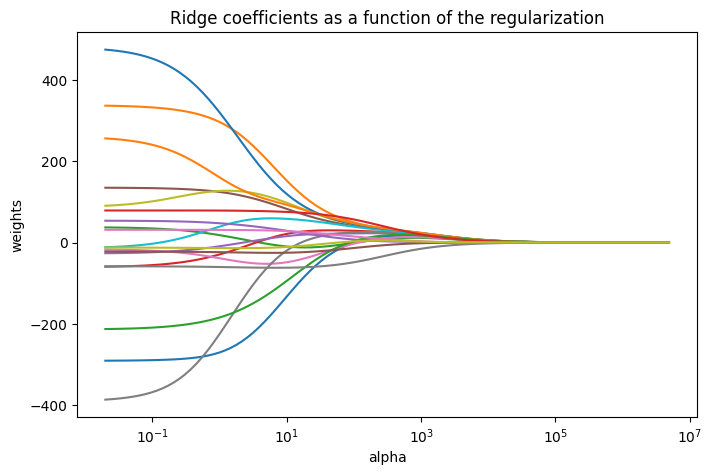

In [30]:
alphas = 5**np.linspace(-2, 10, 100) * 0.5

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, coefs)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Ridge coefficients as a function of the regularization')
plt.show()

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### 3.2.1. Alpha = 4

In [31]:
scaler = StandardScaler().fit(X_train)

In [32]:
ridge = Ridge(alpha=4)
ridge.fit(scaler.transform(X_train), Y_train)
pred = ridge.predict(scaler.transform(X_test))
mean_squared_error(Y_test, pred)

97383.68965102118

In [33]:
pd.Series(ridge.coef_.reshape(-1), index=X.columns)

AtBat         -161.784058
Hits           118.911404
HmRun           52.645719
Runs           -43.295947
RBI             37.339573
Walks          138.214992
Years         -106.916784
CAtBat         -21.080864
CHits          115.933862
CHmRun         -17.949420
CRuns          239.723217
CRBI           -17.945273
CWalks         -59.754770
PutOuts         21.752383
Assists        -68.676906
Errors          89.610291
League_N        31.048268
Division_W     -13.553466
NewLeague_N      4.350305
dtype: float64

#### 3.2.2. Alpha = $10^{10}$  (Alpha graph & find optimal alpha)
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [34]:
ridge = Ridge(alpha=10**10)
ridge.fit(scale(X_train), Y_train)
pred = ridge.predict(scale(X_test))
mean_squared_error(Y_test, pred)

193253.09741651407

In [35]:
pd.Series(ridge.coef_.reshape(-1), index=X.columns)

AtBat          2.291553e-06
Hits           2.428111e-06
HmRun          2.051677e-06
Runs           2.372252e-06
RBI            2.538921e-06
Walks          2.974270e-06
Years          1.572334e-06
CAtBat         2.507043e-06
CHits          2.666936e-06
CHmRun         2.280416e-06
CRuns          2.839982e-06
CRBI           2.526355e-06
CWalks         2.544939e-06
PutOuts        4.880225e-07
Assists       -1.149268e-06
Errors         2.067779e-06
League_N       5.324293e-07
Division_W     5.051366e-07
NewLeague_N    5.291999e-07
dtype: float64

#### 3.2.3. Training mse with different alpha value

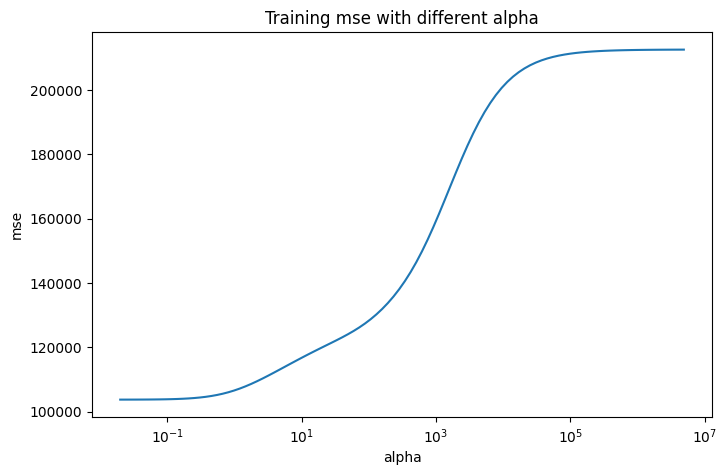

In [36]:
mses = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scaler.transform(X_train), Y_train)
    pred = ridge.predict(scaler.transform(X_train))
    mses.append(mean_squared_error(Y_train, pred))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')
ax.set_title('Training mse with different alpha')
plt.show()

#### 3.2.4. Training mse with different alpha value (Cross validation)

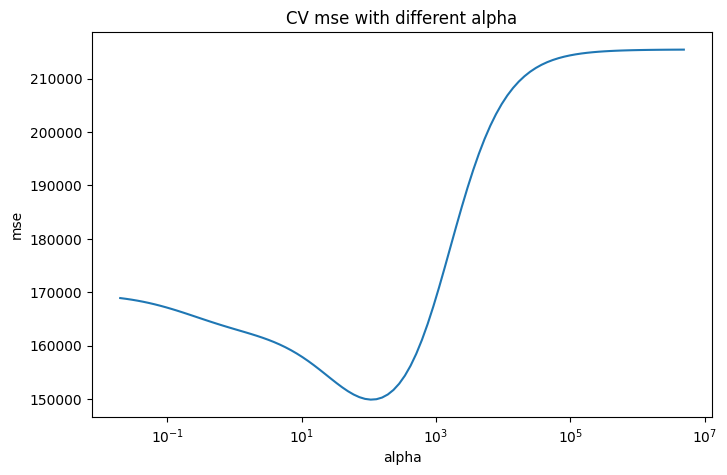

In [37]:
mses = []
for a in alphas:
    ridge = Ridge(alpha=a)
    cv_mses = -cross_val_score(ridge,
                              scale(X_train),
                              Y_train,
                              cv=10,
                              scoring='neg_mean_squared_error')
    mses.append(np.mean(cv_mses))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')
ax.set_title('CV mse with different alpha')
plt.show()

#### 3.2.5. Test mse with different alpha value

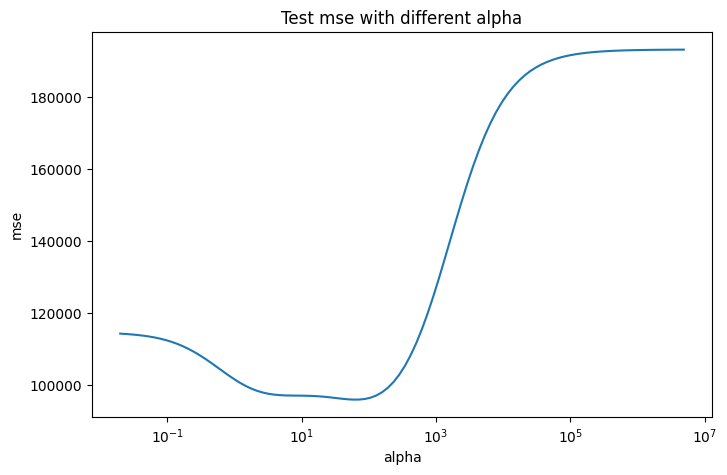

In [38]:
mses = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scaler.transform(X_train), Y_train)
    pred = ridge.predict(scaler.transform(X_test))
    mses.append(mean_squared_error(Y_test, pred))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')
ax.set_title('Test mse with different alpha')
plt.show()

#### 3.2.6. Compute the regularization path using RidgeCV
Ridge regression with built-in cross-validation.

Default cross validation method is "Generalized Cross-Validation" (efficient Leave-One-Out).

In [39]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), Y_train)

RidgeCV(alphas=array([2.00000000e-02, 2.43082465e-02, 2.95445425e-02, 3.59088012e-02,
       4.36439996e-02, 5.30454551e-02, 6.44721001e-02, 7.83601852e-02,
       9.52399351e-02, 1.15755791e-01, 1.40691016e-01, 1.70997595e-01,
       2.07832585e-01, 2.52602285e-01, 3.07015931e-01, 3.73150948e-01,
       4.53532262e-01, 5.51228702e-01, 6.69970160e-01, 8.14289991e-01,
       9.89698093e-01, 1.20289126e+0...
       5.49574280e+04, 6.67959354e+04, 8.11846033e+04, 9.86727677e+04,
       1.19928098e+05, 1.45762089e+05, 1.77161040e+05, 2.15323712e+05,
       2.61707094e+05, 3.18082028e+05, 3.86600818e+05, 4.69879399e+05,
       5.71097214e+05, 6.94118595e+05, 8.43640297e+05, 1.02537082e+06,
       1.24624833e+06, 1.51470558e+06, 1.84099184e+06, 2.23756418e+06,
       2.71956308e+06, 3.30539050e+06, 4.01741235e+06, 4.88281250e+06]),
        scoring='neg_mean_squared_error')

In [40]:
# Optimal alpha that RidgeCV found
ridgecv.alpha_

106.87349666729367

In [41]:
ridge = Ridge(alpha=ridgecv.alpha_)
ridge.fit(scale(X_train), Y_train)
mean_squared_error(Y_test, ridge.predict(scale(X_test)))
# Compare this mse value with an above graph (MSE with different alpha)

97171.90036529173

In [42]:
pd.Series(ridge.coef_.reshape(-1), index=X.columns)

AtBat           6.527403
Hits           22.754323
HmRun          19.213875
Runs           20.029787
RBI            21.072806
Walks          57.407651
Years          -5.790283
CAtBat         20.637323
CHits          29.977244
CHmRun         14.050638
CRuns          37.018236
CRBI           20.284659
CWalks         24.526594
PutOuts        16.522197
Assists       -45.652512
Errors         56.322520
League_N        6.000427
Division_W     -0.571164
NewLeague_N    11.210351
dtype: float64

In [43]:
auto = pd.read_csv(f'{BASE_DIR}/Data/Auto.csv', na_values=['?']).dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


### 3.3 Exercise

Apply Ridge regression to Auto dataset (f'{BASE_DIR}/Data/Auto.csv')
(Y : mpg)

1. Preprocess data
    - Convert quantative variable (origin)
    - Drop irrelevent variable (name) (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html))
    - Standard scale
    
2. Prepare train / test data (train_test_split)
3. Find optimal alpha coefficient using cross validation (refer to 3.4.4)
4. Verify the result using test data (refer to 3.4.5)
5. Try RidgeCV (refer to 3.4.6)


In [44]:
auto = pd.get_dummies(auto, columns=['origin'], drop_first=True)
auto = auto.drop(columns=['name'])
auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin_2      392 non-null    bool   
 8   origin_3      392 non-null    bool   
dtypes: bool(2), float64(4), int64(3)
memory usage: 25.3 KB


In [45]:
Y = auto['mpg']
X = auto.drop(columns=['mpg'])

In [46]:
# Prepare train / test data (train_test_split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
scaler = StandardScaler().fit(X_train)

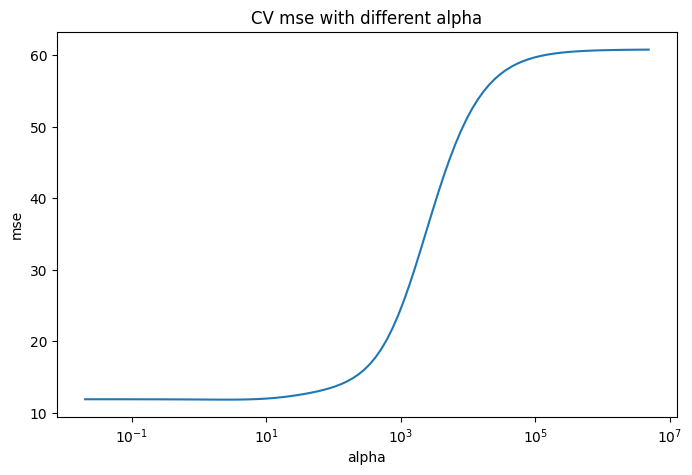

In [47]:
# Find optimal alpha coefficient using cross validation (refer to 3.4.4)
mses = []
for a in alphas:
    ridge = Ridge(alpha=a)
    cv_mses = -cross_val_score(ridge,
                               scaler.transform(X_train),
                               Y_train,
                               cv=10,
                               scoring='neg_mean_squared_error')
    mses.append(np.mean(cv_mses))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')
ax.set_title('CV mse with different alpha')
plt.show()

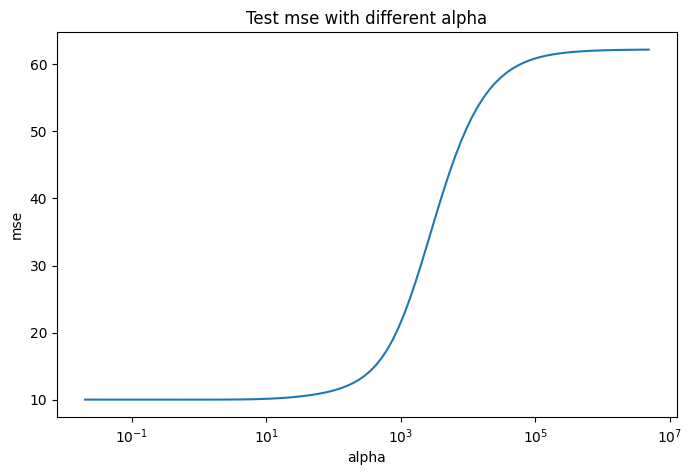

In [48]:
# Verify the result using test data (refer to 3.4.5)
mses = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scaler.transform(X_train), Y_train)
    pred = ridge.predict(scaler.transform(X_test))
    mses.append(mean_squared_error(Y_test, pred))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')
ax.set_title('Test mse with different alpha')
plt.show()

In [49]:
# Try RidgeCV (refer to 3.4.6)
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scaler.transform(X_train), Y_train)

RidgeCV(alphas=array([2.00000000e-02, 2.43082465e-02, 2.95445425e-02, 3.59088012e-02,
       4.36439996e-02, 5.30454551e-02, 6.44721001e-02, 7.83601852e-02,
       9.52399351e-02, 1.15755791e-01, 1.40691016e-01, 1.70997595e-01,
       2.07832585e-01, 2.52602285e-01, 3.07015931e-01, 3.73150948e-01,
       4.53532262e-01, 5.51228702e-01, 6.69970160e-01, 8.14289991e-01,
       9.89698093e-01, 1.20289126e+0...
       5.49574280e+04, 6.67959354e+04, 8.11846033e+04, 9.86727677e+04,
       1.19928098e+05, 1.45762089e+05, 1.77161040e+05, 2.15323712e+05,
       2.61707094e+05, 3.18082028e+05, 3.86600818e+05, 4.69879399e+05,
       5.71097214e+05, 6.94118595e+05, 8.43640297e+05, 1.02537082e+06,
       1.24624833e+06, 1.51470558e+06, 1.84099184e+06, 2.23756418e+06,
       2.71956308e+06, 3.30539050e+06, 4.01741235e+06, 4.88281250e+06]),
        scoring='neg_mean_squared_error')

In [50]:
# Print ridgecv.alpha_
ridgecv.alpha_

2.159719159256476

## 4. The Lasso

### 4.1. Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

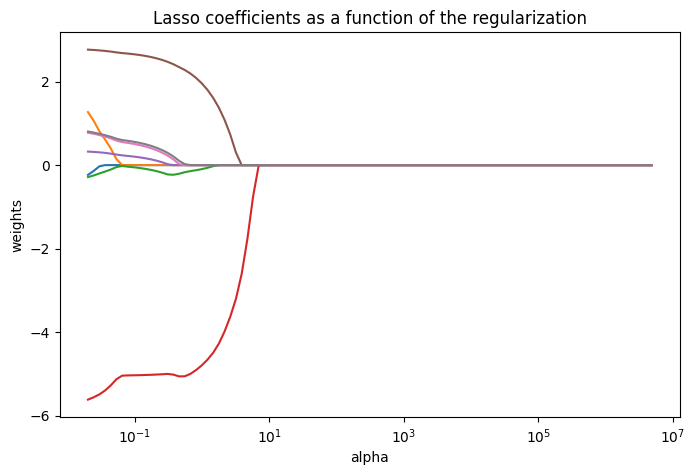

In [51]:
alphas = 5**np.linspace(-2, 10, 100) * 0.5

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(scale(X_train), Y_train)
    coefs.append(lasso.coef_)


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, coefs)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Lasso coefficients as a function of the regularization')
plt.show()

#### 4.1.1. Training mse with different alpha value

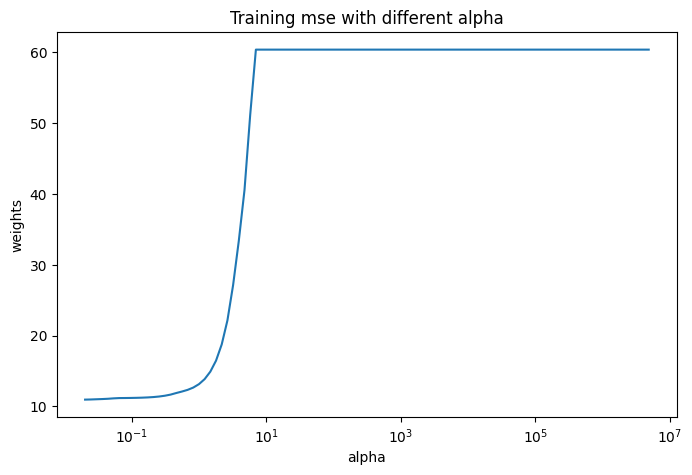

In [52]:
mses = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(scale(X_train), Y_train)
    mses.append(mean_squared_error(Y_train, lasso.predict(scale(X_train))))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Training mse with different alpha')
plt.show()

#### 4.1.2. Training mse with different alpha value (Cross validataion)

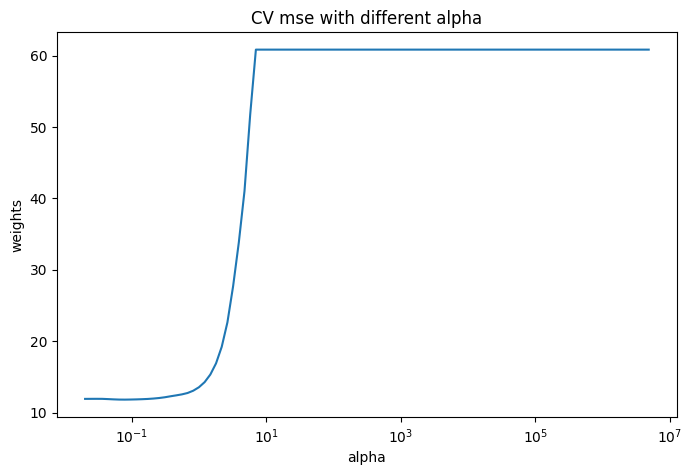

In [53]:
mses = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    cv_mses = -cross_val_score(lasso,
                               scale(X_train),
                               Y_train,
                               cv=10,
                               scoring='neg_mean_squared_error')
    mses.append(np.mean(cv_mses))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('CV mse with different alpha')
plt.show()

####  4.1.3. Test mse with different alpha value

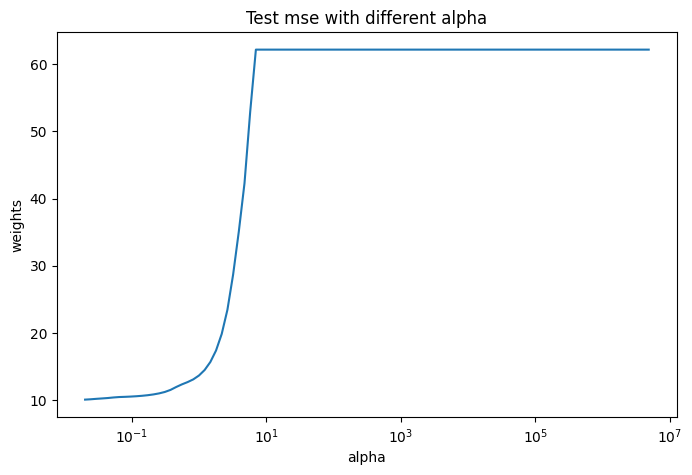

In [54]:
mses = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(scale(X_train), Y_train)
    mses.append(mean_squared_error(Y_test, lasso.predict(scale(X_test))))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Test mse with different alpha')
plt.show()

####  4.1.4. Compute the regularization path using LassoCV
Lasso regression with built-in cross-validation.

Alphas are set automatically

In [55]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), Y_train)

LassoCV(cv=10, max_iter=10000)

In [56]:
lassocv.alpha_

0.07455994494995966

In [57]:
lasso = Lasso(alpha=lassocv.alpha_, max_iter=10000)
lasso.fit(scale(X_train), Y_train)
mean_squared_error(Y_test, lasso.predict(scale(X_test)))

10.472939328401166

In [58]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X_train.columns)

cylinders      -0.000000
displacement    0.000000
horsepower     -0.034365
weight         -5.039013
acceleration    0.223190
year            2.675596
origin_2        0.537672
origin_3        0.587511
dtype: float64

### 4.2 Exercise

Apply Lasso regression to Auto dataset (f'{BASE_DIR}/Data/Auto.csv', Y=mpg)

1. Find optimal alpha coefficient using cross validation (refer to 4.1.2)
2. Verify the result using test data (refer to 4.1.3)
3. Try LassoCV (refer to 4.1.4)

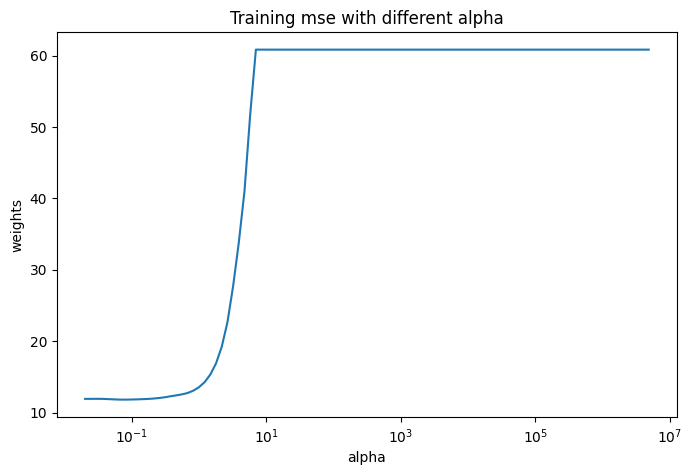

In [59]:
# CV MSE
mses = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    cv_mses = -cross_val_score(lasso,
                               scale(X_train),
                               Y_train,
                               cv=10,
                               scoring='neg_mean_squared_error')
    mses.append(np.mean(cv_mses))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Training mse with different alpha')
plt.show()

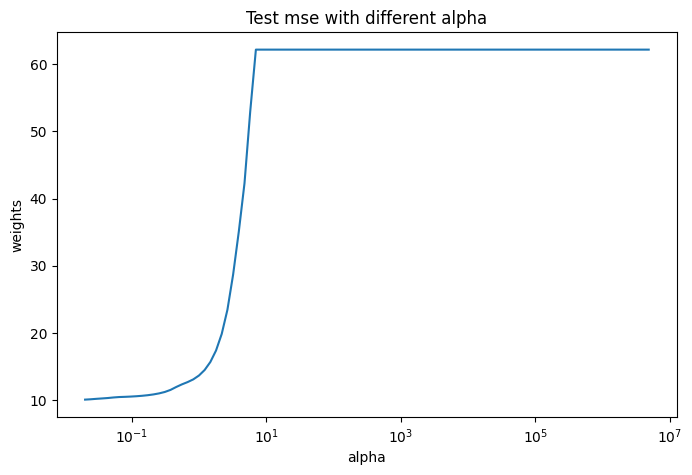

In [60]:
# Test MSE
mses = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(scale(X_train), Y_train)
    mses.append(mean_squared_error(Y_test, lasso.predict(scale(X_test))))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Test mse with different alpha')
plt.show()

In [61]:
# Try LassoCV
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), Y_train)

LassoCV(cv=10, max_iter=10000)

In [62]:
# Print lassocv.alpha_
lassocv.alpha_

0.07455994494995966

## 5. Principal Components Regression

### 5.1 Scikit-learn
Scikit-learn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [63]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(8, 8)


,0,1,2,3,4,5
0,0.441888,-0.031837,-0.151376,0.081125,0.175572,0.714890
1,0.456884,-0.024683,-0.133460,0.059324,0.097296,0.157462
2,0.442761,-0.040070,0.106563,-0.151290,0.207584,-0.571134
3,0.434365,0.027966,-0.238268,0.107497,0.311233,-0.318543
4,-0.303801,0.144227,-0.457488,0.704535,0.305827,-0.127257


The above loadings are the same as in R.

In [64]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(392, 8)


,0,1,2,3,4,5
0,2.634619,0.170603,1.034413,0.327510,-0.495453,0.734493
1,3.377621,0.104023,1.106457,0.110275,-0.252580,0.231408
2,2.988501,0.092571,1.260942,-0.009272,-0.513156,0.525646
3,2.815503,0.148123,1.113627,0.238099,-0.416296,0.459493
4,2.865164,0.081030,1.333021,-0.105200,-0.632778,0.668321


The above principal components are the same as in R.

In [65]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 56.9 ,  73.02,  84.29,  92.38,  97.29,  98.86,  99.59, 100.  ])

#### 5.1.1 Fitting PCA with training data

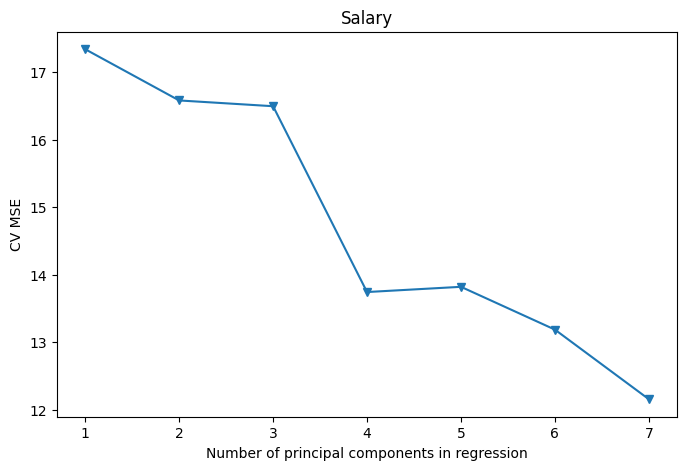

In [66]:
pca = PCA()
X_reduced_train = pca.fit_transform(scale(X_train))

num_elements = [x for x in range(1, X.shape[1])]
mses = []
for i in num_elements:
    cv_mses = -cross_val_score(LinearRegression(),
                               X_reduced_train[:,:i],
                               Y_train,
                               cv=10,
                               scoring='neg_mean_squared_error')
    mses.append(np.mean(cv_mses))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(num_elements, mses, '-v')

ax.set_xlabel('Number of principal components in regression')
ax.set_ylabel('CV MSE')
ax.set_title('Salary')
plt.show()

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### 5.1.2. Transform test data with PCA & compute test result

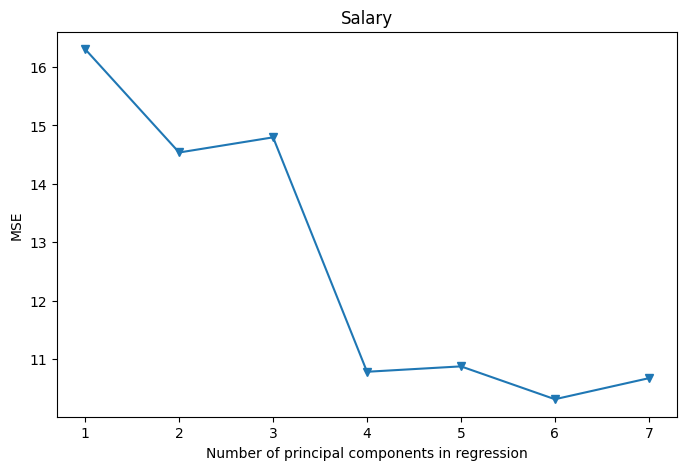

In [67]:
mses = []
for i in num_elements:
    X_reduced_test = pca.transform(scale(X_test))[:,:i]

    # Train regression model on training data
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:i], Y_train)

    # Prediction with test data
    pred = regr.predict(X_reduced_test)
    mses.append(mean_squared_error(Y_test, pred))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(num_elements, mses, '-v')

ax.set_xlabel('Number of principal components in regression')
ax.set_ylabel('MSE')
ax.set_title('Salary')
plt.show()

### 5.2. Excercise
Use PCA to analyze Auto data
(Follow steps from 5.1)


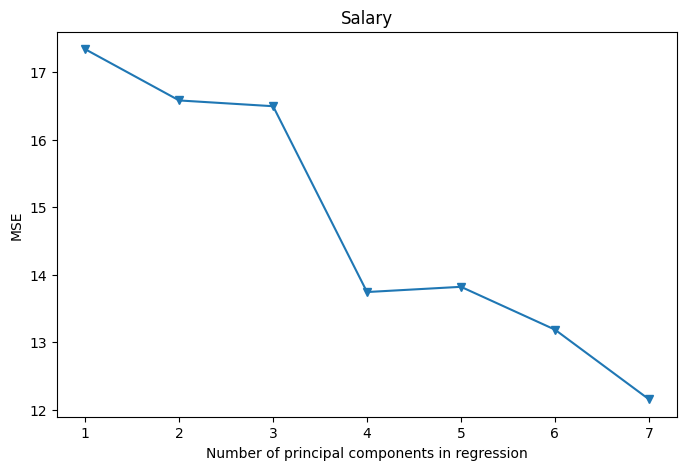

In [68]:
# Fit PCA with auto data
pca = PCA()
X_reduced_train = pca.fit_transform(scale(X_train))

mses = []
for i in num_elements:
    cv_mses = -cross_val_score(LinearRegression(),
                               X_reduced_train[:,:i],
                               Y_train,
                               cv=10,
                               scoring='neg_mean_squared_error')
    mses.append(np.mean(cv_mses))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(num_elements, mses, '-v')

ax.set_xlabel('Number of principal components in regression')
ax.set_ylabel('MSE')
ax.set_title('Salary')
plt.show()

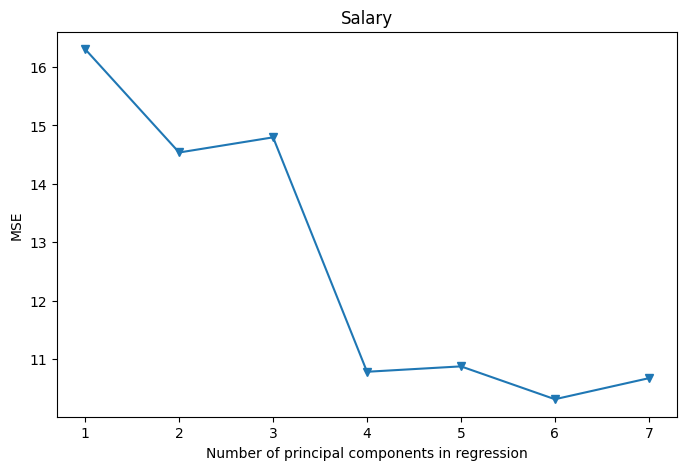

In [69]:
# Transform test data with PCA & compute test result
mses = []
for i in num_elements:
    X_reduced_test = pca.transform(scale(X_test))[:,:i]

    # Train regression model on training data
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:i], Y_train)

    # Prediction with test data
    pred = regr.predict(X_reduced_test)
    mses.append(mean_squared_error(Y_test, pred))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(num_elements, mses, '-v')

ax.set_xlabel('Number of principal components in regression')
ax.set_ylabel('MSE')
ax.set_title('Salary')
plt.show()

## 6. Partial Least Squares

### 6.1. PLSRegression
See documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html

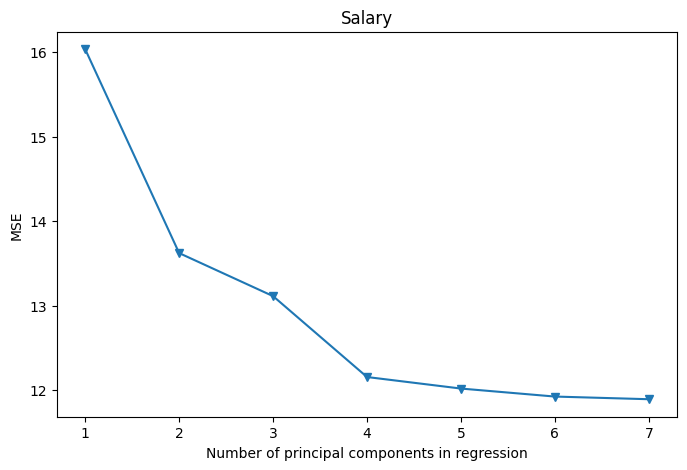

In [70]:
# Select best # of components using CV
mses = []
for i in num_elements:
    pls = PLSRegression(n_components=i)
    cv_mses = -cross_val_score(pls,
                               scale(X_train),
                               Y_train,
                               cv=10,
                               scoring='neg_mean_squared_error')
    mses.append(np.mean(cv_mses))

    # without cross validation
    #pls.fit(scale(X_train), y_train)
    #pred = pls.predict(X_train)
    #mses.append(mean_squared_error(y_train, pred))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(num_elements, mses, '-v')

ax.set_xlabel('Number of principal components in regression')
ax.set_ylabel('MSE')
ax.set_title('Salary')
plt.show()

#### 6.1.1. Test mse with different # of principal components in regression

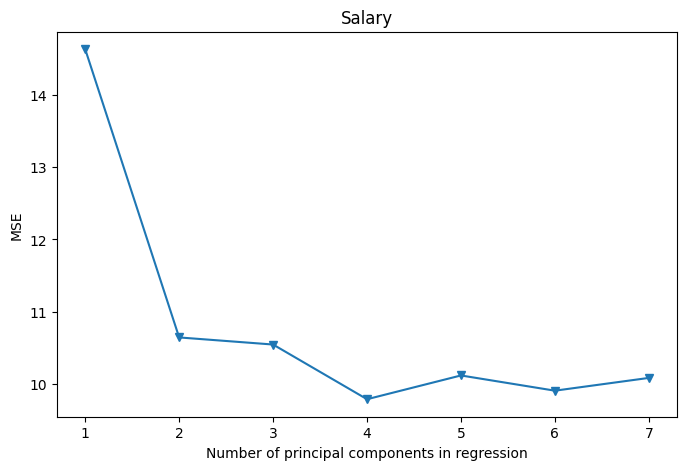

In [71]:
mses = []
for i in num_elements:
    pls = PLSRegression(n_components=i)
    pls.fit(scale(X_train), Y_train)
    mses.append(mean_squared_error(Y_test, pls.predict(scale(X_test))))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(num_elements, mses, '-v')

ax.set_xlabel('Number of principal components in regression')
ax.set_ylabel('MSE')
ax.set_title('Salary')
plt.show()